# Hyperparameter Optimization

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import dl2_torch as d2l
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import torch.nn.functional as F
from collections import Counter
import math
import random
import collections
import re
import json
from scipy import stats
import time

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### [超参数优化](https://d2l.ai/chapter_hyperparameter-optimization/hyperopt-intro.html)  

我们通常为每个超参数分配一个先验分布（例如，均匀分布或对数均匀分布）以进行采样。一些正参数，如 learning_rate ，最好以对数尺度表示，因为最优值可能相差几个数量级，而其他参数，如动量，则使用线性尺度。  

In [12]:
sampler = stats.loguniform(1e-4, 1)  # 它表示对数空间中-4 到-1 之间的均匀分布,此对象允许我们从该分布中抽取随机变量
sampler.rvs()  # 进行采样

0.3162287811858784

#### 随机搜索
从定义好的参数分布中随机采样
```python
for i in range(num_iterations):
    learning_rate = config_space["learning_rate"].rvs()
    print(f"Trial {i}: learning_rate = {learning_rate}")
    y = hpo_objective_softmax_classification({"learning_rate": learning_rate})
    print(f"    validation_error = {y}")
    values.append(learning_rate)
    errors.append(y)
```  

随机搜索也存在一些不足。首先，它没有根据迄今为止收集到的先前观察结果调整采样分布。因此，它以相同概率采样表现较差的配置或表现较好的配置。  
其次，所有配置都投入了相同数量的资源，尽管其中一些可能表现出较差的初始性能，并且不太可能优于之前看到的配置。

## 高级搜索方式  
这里考虑的所有 HPO 算法都需要实现两个决策原语：搜索和调度。  
首先，它们需要采样新的超参数配置，这通常涉及对配置空间的某种搜索。其次，对于每个配置，HPO 算法需要安排其评估并决定为其分配多少资源。  
一旦我们开始评估一个配置，我们将其称为试验。我们将这些决策映射到两个类， HPOSearcher 和 HPOScheduler 。在此基础上，我们还提供了一个 HPOTuner 类来执行优化过程。

### Searcher  
以下我们定义了一个搜索器的基类，该类通过 sample_configuration 函数提供新的候选配置。  
实现此函数的一种简单方法是在随机搜索中我们那样均匀随机采样配置。  
更复杂的算法，如**贝叶斯优化**，将根据先前试验的性能做出这些决策。因此，这些算法能够随着时间的推移采样更有希望的候选者。  
我们添加 update 函数是为了更新先前试验的历史记录，然后可以利用这些记录来改进我们的采样分布。

基于前一个实验结果选择参数： 例如以多少概率选择之前error 最小的参数组， 随机修改其中一个参数作为新的参数组

In [ ]:
class HPOSearcher(d2l.HyperParameters):
    def sample_configuration() -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, additional_info=None):
        pass

In [3]:
class RandomSearcher(HPOSearcher):
    def __init__(self, config_space: dict, initial_config=None):  # initial_config 作为用户指定的第一组参数配置
        self.save_hyperparameters()

    def sample_configuration(self) -> dict:
        if self.initial_config is not None:
            result = self.initial_config
            self.initial_config = None
        else:
            result = {
                name: domain.rvs()
                for name, domain in self.config_space.items()
            }
        return result

### Scheduler  
为新试验选择采样配置之外，我们还需要决定何时以及持续多长时间进行试验。在实践中，所有这些决定都由 HPOScheduler 做出，它将新配置的选择委托给 HPOSearcher 。  
每当有训练资源可用时，就会调用 suggest 方法。除了调用搜索器的 sample_configuration 之外，它还可能决定诸如 max_epochs （即训练模型多长时间）之类的参数。  
每当试验返回新的观察结果时，就会调用 update 方法。

In [4]:
class HPOScheduler(d2l.HyperParameters):
    def suggest(self) -> dict:
        raise NotImplementedError

    def update(self, config: dict, error: float, info=None):
        raise NotImplementedError

In [5]:
class BasicScheduler(HPOScheduler):
    def __init__(self, searcher: HPOSearcher):
        self.save_hyperparameters()

    def suggest(self) -> dict:
        return self.searcher.sample_configuration()

    def update(self, config: dict, error: float, info=None):
        self.searcher.update(config, error, additional_info=info)

### Tuner  
最后，我们需要一个运行调度器/搜索器并记录结果的组件。以下代码实现了对 HPO 试验的顺序执行

In [6]:
class HPOTuner(d2l.HyperParameters):  #@save
    def __init__(self, scheduler: HPOScheduler, objective: callable):
        self.save_hyperparameters()
        # Bookeeping results for plotting
        self.incumbent = None  # 保留最佳配置
        self.incumbent_error = None  # 保留最佳error
        self.incumbent_trajectory = []
        self.cumulative_runtime = []
        self.current_runtime = 0
        self.records = []  # 保留测试记录

    def run(self, number_of_trials):
        for i in range(number_of_trials):
            start_time = time.time()
            config = self.scheduler.suggest()
            print(f"Trial {i}: config = {config}")
            error = self.objective(**config)
            error = float(error.cpu().detach().numpy())
            self.scheduler.update(config, error)
            runtime = time.time() - start_time
            self.bookkeeping(config, error, runtime)
            print(f"    error = {error}, runtime = {runtime}")

    def bookkeeping(self, config: dict, error: float, runtime: float):
        self.records.append({"config": config, "error": error, "runtime": runtime})
        # Check if the last hyperparameter configuration performs better
        # than the incumbent
        if self.incumbent is None or self.incumbent_error > error:
            self.incumbent = config
            self.incumbent_error = error
        # Add current best observed performance to the optimization trajectory
        self.incumbent_trajectory.append(self.incumbent_error)
        # Update runtime
        self.current_runtime += runtime
        self.cumulative_runtime.append(self.current_runtime)

### 超参数调优

In [7]:
def hpo_objective_lenet(learning_rate, batch_size, max_epochs=10):
    model = d2l.LeNet(lr=learning_rate, num_classes=10)
    trainer = d2l.HPOTrainer(max_epochs=max_epochs, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size,resize=(28, 28), num_workers=0)
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model=model, data=data)
    validation_error = trainer.validation_error()
    return validation_error

In [8]:
config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

    error = 0.20849978923797607, runtime = 96.65404105186462


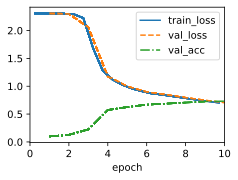

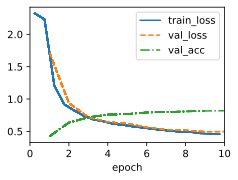

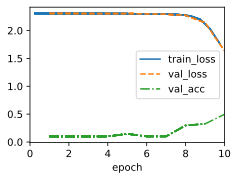

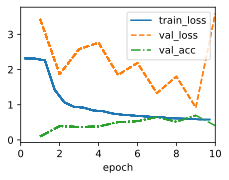

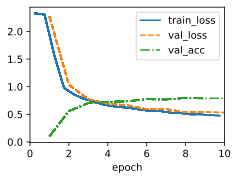

In [9]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = BasicScheduler(searcher=searcher)
tuner = HPOTuner(scheduler=scheduler, objective=hpo_objective_lenet)
tuner.run(number_of_trials=5)

## 使用异步调优方法
我们可以通过将分布试验并行资源来显著减少随机搜索的等待时间。  
一般来说，我们区分同步调度和异步调度。同步调度意味着在前一批次完成之后，我们采样一批新的超参数配置。如果我们有落后者——即完成时间比其他试验更长的试验——我们的工作者需要在同步点等待。  
异步调度在资源可用时立即评估新的超参数配置，因此确保在任何时间点所有工作者都处于忙碌状态。  
虽然随机搜索易于异步分布且不需要对实际算法进行任何更改，但其他方法需要一些额外的修改。


```python 
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
from syne_tune import StoppingCriterion, Tuner  # syne_tune 为异步调优库
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import RandomSearch
```

## Multi-Fidelity Hyperparameter Optimization  
[多保真超参数优化](https://d2l.ai/chapter_hyperparameter-optimization/sh-intro.html)  
核心思想是在每个时间步中仅运行少部分实验， 在该时间段结束后，删去分数低的参数组，继续评估剩下分数高的参数组， 只到仅剩下一组  



<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411081543244.png" width='400px' >
</div>   


### SuccessiveHalvingScheduler  
逐次减半方法  

参数选择 $ r_{max} = r_{\mathrm{min}} \eta^K $, $ \eta $由用户确定  
np.log(r_max / r_min) / np.log(eta) = log eta (r_max / r_min)  
 

每轮测试时，模型均从随机初始化参数训练 max_epochs 次

In [ ]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):
        self.save_hyperparameters()
        # Compute K, which is later used to determine the number of configurations
        self.K = int(np.log(r_max / r_min) / np.log(eta))   # 当 K 为最大轮数时， 对应的运行时间达到 r_max
        # Define the rungs
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            # The final rung should be r_max
            self.rung_levels.append(r_max)
            self.K += 1
        # Bookkeeping
        self.observed_error_at_rungs = collections.defaultdict(list)
        self.all_observed_error_at_rungs = collections.defaultdict(list)
        # Our processing queue
        self.queue = []

    def suggest(self):
        #  从现有队列中选取一组参数，如果队列为空表示一轮迭代已跑完，重新生成一组配置
        if len(self.queue) == 0:
            # Start a new round of successive halving
            # Number of configurations for the first rung:
            n0 = int(self.prefact * self.eta ** self.K)  # 生成第一轮运行所需的配置数目
            for _ in range(n0):
                config = self.searcher.sample_configuration()
                config["max_epochs"] = self.r_min  # Set r = r_min
                self.queue.append(config)
        # Return an element from the queue
        return self.queue.pop()
    
    def update(self, config: dict, error: float, info=None):
        # 当我们收集到一个新的数据点时，我们首先更新搜索器模块。之后，我们检查是否已经收集了当前阶段的全部数据点。如果是，我们将所有配置排序并将顶部配置推入队列。 
        ri = int(config["max_epochs"])  # Rung r_i  max_epochs 用于确定目前在哪一轮，且该轮中模型需要训练的 epochs 数
        # Update our searcher, e.g if we use Bayesian optimization later
        self.searcher.update(config, error, additional_info=info)
        self.all_observed_error_at_rungs[ri].append((config, error))
        if ri < self.r_max:
            # Bookkeeping
            self.observed_error_at_rungs[ri].append((config, error))
            # Determine how many configurations should be evaluated on this rung
            ki = self.K - self.rung_levels.index(ri)
            ni = int(self.prefact * self.eta ** ki)
            # If we observed all configuration on this rung r_i, we estimate the
            # top 1 / eta configuration, add them to queue and promote them for
            # the next rung r_{i+1}
            if len(self.observed_error_at_rungs[ri]) >= ni:
                kiplus1 = ki - 1
                niplus1 = int(self.prefact * self.eta ** kiplus1)
                best_performing_configurations = self.get_top_n_configurations(
                    rung_level=ri, n=niplus1
                )
                riplus1 = self.rung_levels[self.K - kiplus1]  # r_{i+1}
                # Queue may not be empty: insert new entries at the beginning
                self.queue = [
                    dict(config, max_epochs=riplus1)  
                    for config in best_performing_configurations
                ] + self.queue
                self.observed_error_at_rungs[ri] = []  # Reset

    def get_top_n_configurations(self, rung_level, n):
        rung = self.observed_error_at_rungs[rung_level]
        if not rung:
            return []
        sorted_rung = sorted(rung, key=lambda x: x[1])
        return [x[0] for x in sorted_rung[:n]]

In [24]:
dict({1:'a', 2:'b', 'c':3}, d=4)  # 字段 key 需要为字符串

{1: 'a', 2: 'b', 'c': 3, 'd': 4}

### 测试  

让我们看看连续减半在我们的神经网络示例中的表现。我们将使用 rmin=2 ， η=2 ， rmax=10 ，以便运行级别为 2,4,8,10 。

In [25]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2
num_gpus=1

config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

一共评估 number_of_trials 次， 每轮参数由 scheduler 给出

In [ ]:
searcher = RandomSearcher(config_space, initial_config=initial_config)
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs,
)
tuner = HPOTuner(
    scheduler=scheduler,
    objective=hpo_objective_lenet,
)
tuner.run(number_of_trials=30)

Text(0.5, 0, 'epochs')

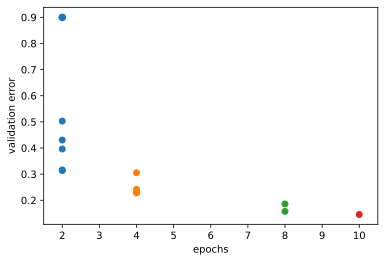

In [29]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung]
    d2l.plt.scatter([rung_index] * len(errors), errors)
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)
d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1)
)
d2l.plt.ylabel("validation error")
d2l.plt.xlabel("epochs")

## Asynchronous successive halving (ASHA)
异步连续减半  

与随机搜索相比，在异步分布式环境中，连续减半法并不那么简单易行。  
为了避免同步点，我们尽可能快地将配置提升到下一个级别，即使这意味着提升一些错误的配置。  
在实践中，这通常不会造成太大伤害，异步调度与同步调度的收益通常远高于次优决策的损失。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411081704480.png" width='600px' >
</div>   

```python
import logging
from d2l import torch as d2l

logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt
from syne_tune import StoppingCriterion, Tuner
from syne_tune.backend.python_backend import PythonBackend
from syne_tune.config_space import loguniform, randint
from syne_tune.experiments import load_experiment
from syne_tune.optimizer.baselines import ASHA  # 使用异步减半超参数优化算法
```